In [95]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [118]:
#CARREGAR OS DADOS
caminho_arquivo = "gold_standard_id.csv"
dados = pd.read_csv(caminho_arquivo)


ecg_normal_linhas = dados.index[
                                (dados.iloc[:, 1] == 0) & 
                                (dados.iloc[:, 2] == 0) & 
                                (dados.iloc[:, 3] == 0) & 
                                (dados.iloc[:, 4] == 0) & 
                                (dados.iloc[:, 5] == 0) & 
                                (dados.iloc[:, 6] == 0)]

ecg_doente_linhas = dados.index[
                                (dados.iloc[:, 1] == 0) & 
                                (dados.iloc[:, 2] == 0) & 
                                (dados.iloc[:, 3] == 0) & 
                                (dados.iloc[:, 4] == 0) & 
                                (dados.iloc[:, 5] == 0) & 
                                (dados.iloc[:, 6] == 1)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:10000]

ids_ecgs= ecg_doente_id + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 681
Número de linhas ecg_doente_linhas: 35
Número de ecgs pra clusterizar: 716


In [ ]:
import h5py
import numpy as np
import pandas as pd

# Arquivos
hdf5_file = 'ecg_tracings.hdf5'
gold_standard_file = 'gold_standard_id.csv'

# Passo 1: Ler o arquivo HDF5 com os traçados ECG
with h5py.File(hdf5_file, "r") as f:
    tracings = np.array(f['tracings'])

# Passo 2: Ler o arquivo CSV
df = pd.read_csv(gold_standard_file)

# Passo 4: Colocar todos os traçados na ordem dos IDs de exame em um vetor
# Filtrar os traçados pelos IDs selecionados
ordered_tracings = []
for exam_id in ids_ecgs:
    if exam_id < len(tracings):
        ordered_tracings.append(tracings[exam_id])

# Converter a lista para um array numpy
ordered_tracings = np.array(ordered_tracings)

# Passo 5: Aplicar o filtro em todos os leads de todos os exames
filtered_tracings = np.zeros_like(ordered_tracings)

for i in range(ordered_tracings.shape[0]):
    for lead in range(ordered_tracings.shape[2]):  # Iterar sobre os 12 leads
        filtered_tracings[i, :, lead] = ecg_filtrado(ordered_tracings[i, :, lead])

# Exemplo: Imprimir informações sobre o primeiro exam_id e seu traçado filtrado correspondente
first_exam_id = df['exam_id'].iloc[0]
first_filtered_tracing = filtered_tracings[0]
print(f"Primeiro traçado filtrado do exam_id {first_exam_id}: {first_filtered_tracing}")

print(df.head())  # Ver as primeiras linhas do DataFrame para verificar os dados

# Exemplo: Imprimir todos os traçados filtrados
print(f"Traçados filtrados: {filtered_tracings}")

X = np.array(filtered_tracings)
 
# Usando squeeze
X = np.squeeze(X[:, :, 1])

In [ ]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)
autoencoder = tf.keras.models.load_model('../modelos/autoencoder_model.keras')
# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

# Substituir os valores NaN por epsilon
epsilon = 1e-10
X_encoded_2d = np.nan_to_num(X_encoded_2d, nan=epsilon)

In [127]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=64, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

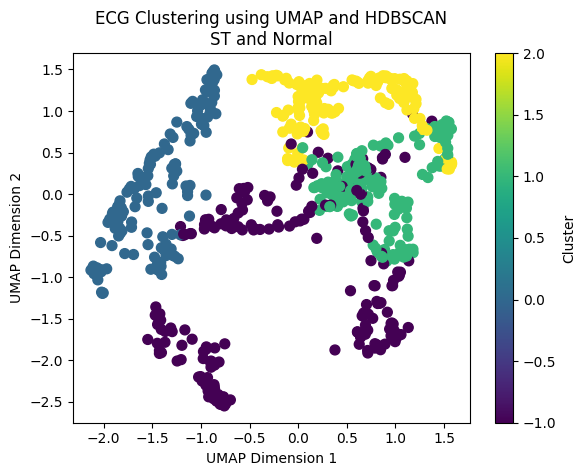

Silhouette Score: 0.21333779394626617
F1 Score: 0.3679662023812534
   cluster  1dAVb  RBBB  LBBB  SB  ST  AF  normal_ecg
0       -1      0     0     0   0   3   0         203
1        0      0     0     0   0   0   0         150
2        1      0     0     0   0  32   0         171
3        2      0     0     0   0   0   0         157


C:\Users\pedro\AppData\Local\Temp\ipykernel_9524\3835112514.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()


In [128]:
#CLUSTERIZACAO HDBSCAN
from sklearn.metrics import silhouette_score, f1_score
import numpy as np

# Clusterização HDBSCAN
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=100, min_samples=5)
labels = dbscan.fit_predict(X_reduced_scaled)
# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN\nST and Normal')
plt.colorbar(label='Cluster')
plt.show()

# Calcular e imprimir os scores
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("gold_standard_id.csv")
exam_ids_to_cluster = ids_ecgs
# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Determinar o rótulo verdadeiro para cada cluster com base na maioria
def determine_majority_label(cluster_data):
    normal_count = cluster_data['normal_ecg'].sum()
    disease_count = cluster_data[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum().sum()
    return 'normal' if normal_count > disease_count else 'disease'

# Aplicar a função para determinar o rótulo majoritário de cada cluster
majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()
majority_labels.columns = ['cluster', 'majority_label']

# Mesclar os rótulos majoritários com os dados agrupados
merged_data = merged_data.merge(majority_labels, on='cluster')

# Criar rótulos verdadeiros
def assign_true_label(row):
    if row['majority_label'] == 'normal':
        return row['normal_ecg'] == 1
    else:
        return row[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum() > 0

merged_data['true_label'] = merged_data.apply(assign_true_label, axis=1)

# Calcular o F1 score
true_labels = merged_data['true_label']
f1_avg = f1_score(true_labels, labels, average='weighted')
print(f'F1 Score: {f1_avg}')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)